# I. Train and test datasets

In [1]:
# Hyperparameters for dataset

D = 784 #dimension
k = 3 # num of 2d planes in dim D
n = 6*(10**3) # num of points in each plane
#n = 10**3 # num of points in each plane

batch_size  = 16
split_ratio = 0.2
shift_class = 0

# Set manual seed for reproducibility
# torch.manual_seed(0)

In [2]:
from torch.nn.functional import normalize
from tqdm import tqdm
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import plotly.express as px
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

phi = [] #list of k ontonormal bases in k planes
for j in range(k):
    # creating random planes
    rand_vectors = torch.rand(D, 2)
    q, r = torch.qr(rand_vectors)
    phi.append(q)
#phi

#creating samples from normal distributions via torch distributions
data = []
for i in range(k):
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2) + shift_class*(i+1), torch.eye(2))
    #m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))
    samples = m.sample(sample_shape=(n,)).T
    #samples = normalize(samples, p = 1, dim = 0)
    #data.append(normalize(torch.matmul(phi[i], samples)))
    data.append(torch.matmul(phi[i], samples))
data_tensor = torch.cat(data, dim=1)

data_tensor = data_tensor.T
data_tensor = data_tensor.reshape(k*n, 1, 28, 28)

labels_list = []
for i in range(k):
    labels_list.append(i*(torch.ones(n)))
labels = torch.cat(labels_list)

my_set = TensorDataset(data_tensor,labels)
train_dataset = my_set

train_transform = transforms.Compose([
transforms.ToTensor(),
])


train_dataset.transform = train_transform

m=len(train_dataset)

train_data, test_data = random_split(train_dataset, [int(m-m*split_ratio), int(m*split_ratio)])

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# test_data[:][0] will give the vectors of data without labels from the test part of the dataset

/tmp/ipykernel_92306/775956703.py:20: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2425.)
  q, r = torch.qr(rand_vectors)


## TSNE check

In [3]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd  

In [4]:
#tsne check on test set
#synthetic_set = data_tensor.reshape(-1,28*28)
synthetic_set = test_data[:][0].view(-1,28*28)

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(synthetic_set.numpy())
df = pd.DataFrame()
#df["y"] = labels.numpy()
df["y"] = test_data[:][1].numpy() #test_data[:][1] are labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3600 samples in 0.001s...
[t-SNE] Computed neighbors for 3600 samples in 0.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3600
[t-SNE] Computed conditional probabilities for sample 2000 / 3600
[t-SNE] Computed conditional probabilities for sample 3000 / 3600
[t-SNE] Computed conditional probabilities for sample 3600 / 3600
[t-SNE] Mean sigma: 0.178636
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.581421
[t-SNE] KL divergence after 1000 iterations: 0.652200


/tmp/ipykernel_92306/2306197446.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'Synthetic dataset data T-SNE projection')]

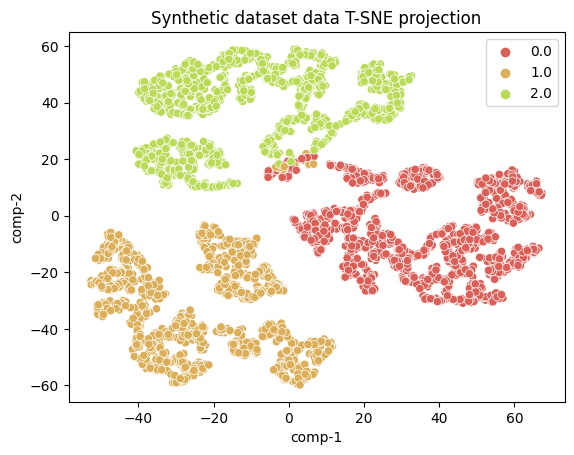

In [5]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="Synthetic dataset data T-SNE projection")

# II. Declaration of VAE

In [6]:
# Check if the GPU is available
cuda_on = torch.cuda.is_available()
if cuda_on:
    device  = torch.device("cuda") 
else :
    device = torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [7]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, cuda=False):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dim, 512)
        self.linear2 = nn.Linear(512, hidden_dim)
        self.linear3 = nn.Linear(512, hidden_dim)
        
        self.N = torch.distributions.Normal(0, 1)
        if cuda:
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        #self.encoder = nn.Linear(input_dim, hidden_dim)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128, bias=True),
            nn.LeakyReLU(),
            nn.Linear(128, 128, bias=True),
            nn.LeakyReLU(),
            nn.Linear(128, hidden_dim, bias=True),
        )
        self.kl = 0 # For compatibility
        
    def forward(self, x):
        out = self.encoder(x)
        # out = torch.relu(out)
        #out = torch.sin(out)
        #out = torch.sigmoid(out)
        #out = F.leaky_relu(out)
        return out

class Decoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        #self.decoder = nn.Linear(hidden_dim, output_dim)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128, bias=True),
            nn.LeakyReLU(),
            nn.Linear(128, 128, bias=True),
            nn.LeakyReLU(),
            nn.Linear(128, output_dim, bias=True),
            nn.LeakyReLU()
        )
    def forward(self, x):
        out = self.decoder(x)
        #out = torch.sigmoid(out)
        return out

In [9]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr  = 1e-3
klw = 0.0

### Set the random seed for reproducible results
# torch.manual_seed(0)

### Initialize the two networks
d = 2

In [10]:
# Classical
#model = Autoencoder(hidden_dim=hidden_dim)
encoder = Encoder(input_dim=784, hidden_dim=d)
decoder = Decoder(hidden_dim=d, output_dim=784)

# VAE
#encoder = VariationalEncoder(input_dim=784, hidden_dim=d, cuda=cuda_on)
#decoder = Decoder(hidden_dim=d, output_dim=784)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optimizer = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=0.0)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)

# III. Training

In [11]:
def point_plot(mydata):
    s = encoder(mydata[:][0].view(-1,1,28*28)).detach().numpy()
    s = s.reshape(-1, 2)
    l = mydata[:][1].numpy().reshape(-1,1)
    s = np.concatenate((s,l),axis=1)
    myplot = px.scatter(s, x = s[:,0], y = s[:,1], color=s[:,2].astype(str), opacity=0.5)
    return myplot    

In [12]:
# Batches per epoch
print( "Reality check of batch splitting: ")
print( "-- Batches per epoch", len(train_loader) )
print( "batch size:", batch_size )
print( "product: ", len(train_loader)*batch_size )
print( "-- To be compared to:", (1.0-split_ratio)*n*k)


Reality check of batch splitting: 
-- Batches per epoch 900
batch size: 16
product:  14400
-- To be compared to: 14400.0


In [13]:
### Training function

def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    mse_loss = []
    
    batch_idx = 0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        #shaping the images properly
        image_batch = image_batch.view(-1,28*28)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)

        # Evaluate loss
        optimizer.zero_grad()
        loss = loss_fn(decoded_data, image_batch) + klw*encoder.kl

        # Backward pass
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        #print(batch_idx)

        #print('\t partial train loss (single batch): {:.6} \t curv_loss {:.6} \t mse {:.6}'.format(loss.data, new_loss, only_mse.data))
        
        mse_loss.append(float(loss.detach().cpu().numpy()))

        batch_idx += 1

    #return np.mean(train_loss), np.mean(mse_loss) 
    return mse_loss 

In [14]:
num_epochs = 20
#diz_loss = {'train_loss':[],'mse_loss':[]}
diz_loss = {'train_loss':[]}

for epoch in range(num_epochs):

   #old
   #train_info = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)

   # Set train mode for both the encoder and the decoder
   encoder.train()
   decoder.train()
   mse_loss = []
   
   batch_idx = 0
   # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
   for image_batch, _ in train_loader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
      #shaping the images properly
      image_batch = image_batch.view(-1,28*28)
      # Move tensor to the proper device
      image_batch = image_batch.to(device)
      # True batch size
      true_batch_size = image_batch.shape[0]

      optimizer.zero_grad()
      
      # Encode data
      encoded_data = encoder(image_batch)
      # Decode data
      decoded_data = decoder(encoded_data)

      # Evaluate loss
      #loss = loss_fn(decoded_data, image_batch) + klw*encoder.kl
      loss = torch.sum( (decoded_data-image_batch)**2 )/true_batch_size

      # Backward pass
      loss.backward()
      optimizer.step()
      # Print batch loss
      print('\t Partial train loss (single batch): %f' % (loss.data))
      #print(batch_idx)

      #print('\t partial train loss (single batch): {:.6} \t curv_loss {:.6} \t mse {:.6}'.format(loss.data, new_loss, only_mse.data))
      
      mse_loss.append(float(loss.detach().cpu().numpy()))

      batch_idx += 1
   # end for
   
   train_info = mse_loss
   train_loss = np.mean(train_info)
   
   print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs, train_loss))
   #plot = point_plot(test_data.cpu())
   #plot.show()
   
   diz_loss['train_loss'].append(train_info)
   
diz_loss['train_loss'] = np.array(diz_loss['train_loss']).flatten()
#diz_loss['mse_loss'] = np.array(diz_loss['mse_loss']).flatten()

	 Partial train loss (single batch): 5.306422
	 Partial train loss (single batch): 3.158487
	 Partial train loss (single batch): 2.535723
	 Partial train loss (single batch): 1.666234
	 Partial train loss (single batch): 1.028418
	 Partial train loss (single batch): 1.825405
	 Partial train loss (single batch): 1.732884
	 Partial train loss (single batch): 1.429092
	 Partial train loss (single batch): 1.182889
	 Partial train loss (single batch): 1.165721
	 Partial train loss (single batch): 2.304132
	 Partial train loss (single batch): 2.159645
	 Partial train loss (single batch): 1.372286
	 Partial train loss (single batch): 2.034398
	 Partial train loss (single batch): 2.209312
	 Partial train loss (single batch): 1.558514
	 Partial train loss (single batch): 1.703502
	 Partial train loss (single batch): 2.240923
	 Partial train loss (single batch): 1.863319
	 Partial train loss (single batch): 1.952354
	 Partial train loss (single batch): 1.717888
	 Partial train loss (single batch

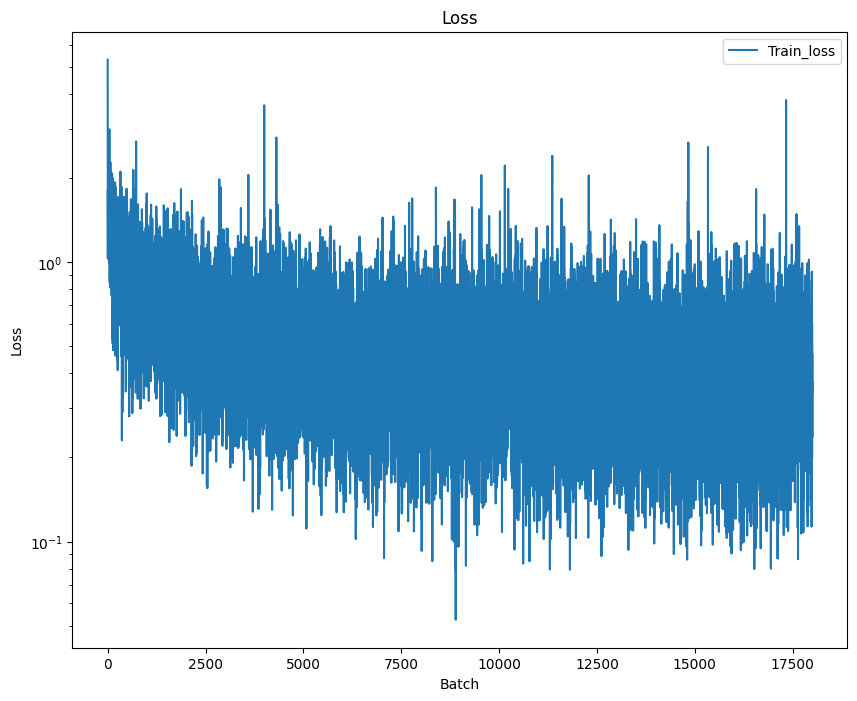

In [15]:
# Plot losses

plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train_loss')
#plt.semilogy(diz_loss['train_loss'] - diz_loss['mse_loss'], label='Curv_loss')
plt.title('Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [16]:
from tqdm import tqdm

encoded_samples     = []
encoded_samples_raw = []
#for sample in tqdm(train_dataset):
for sample in tqdm(test_data):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        img = img.view(-1,28*28) # reshape the img
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_sample_raw = np.array( [encoded_img[0], encoded_img[1], label] )
    encoded_samples.append(encoded_sample)
    encoded_samples_raw.append( encoded_sample_raw )

100%|██████████| 3600/3600 [00:01<00:00, 3301.66it/s]


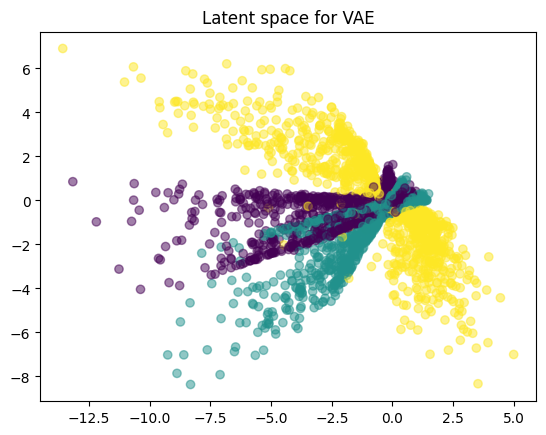

In [17]:
code_array = np.array( encoded_samples_raw )
plt.scatter( code_array[:,0], code_array[:,1], c=code_array[:,2], alpha=0.5 )
plt.title( "Latent space for VAE")
#plt.legend()
plt.show()

In [18]:
encoded_samples_df = pd.DataFrame(encoded_samples)
encoded_samples_df

,Enc. Variable 0,Enc. Variable 1,label
0,0.058720,-0.314762,tensor(1.)
1,-0.234490,-0.806057,tensor(1.)
2,0.278036,-0.248071,tensor(1.)
3,-3.528398,-2.003748,tensor(0.)
4,0.530790,-0.111728,tensor(1.)
...,...,...,...
3595,1.751490,-1.705074,tensor(2.)
3596,1.359539,-2.755455,tensor(2.)
3597,-1.040223,0.362004,tensor(2.)
3598,-0.042778,0.219060,tensor(1.)


In [19]:
import plotly.express as px

px.scatter(encoded_samples_df, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples_df.label.astype(str), opacity=0.5)